## Generate Synthetic AllOfUs Data for A Given State

Generate synthetic data that matches the AllOfUs univariate distributions for a given state. Ignores correlations between variables and does not attempt to preserve conditional distributions.

In [1]:
import os
import re
import sys
import math
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from collections import Counter

from src import ecdf, pdf, plots, coding_aou_raw as CODING

#### PARAMETERS

In [2]:
# directory where the input files are found
DATA_DIR = 'data'

# number of synthetic tuples to generate
NUM_SAMPLES = 500000

# name of file containing the state abbreviations and the number of records for each state
AOU_STATE_COUNT_FILE = 'allofus_state_counts.txt'

# recoded PUMS file, needed to filter recoded AOU tuples to those actually occurring in the PUMS data
# (assumed to be located in the data directory)
PUMS_RECODED_FILENAME = 'pums_usa_2020_recoded_aou.csv'

# map of variable enum to column name in recoded pums file
VARIABLE_DATA = [
    # variable enum,              # recoded PUMS var name
    (CODING.Variables.AGE,        'Age'),          
    (CODING.Variables.RACE_ETH,   'RaceEth'),
    (CODING.Variables.INSURANCE,  'Insurance'),
    (CODING.Variables.EDUCATION,  'Education'),
    (CODING.Variables.INCOME,     'Income'),
    (CODING.Variables.SEX,        'Sex'),
]

# map from variable names to output file column names
OUTPUT_VAR_MAP = {
    'Age'       : 'AGE_GROUPING',
    'RaceEth'   : 'RACE_GROUPING',
    'Insurance' : 'INSURANCE_GROUPING',
    'Education' : 'EDUCATION_GROUPING',
    'Income'    : 'INCOME_GROUPING',
    'Sex'       : 'SEX_AT_BIRTH',
}

# output will be written here
OUTPUT_FILE = 'data/synthetic_aou.csv'
print('Synthetic data will be written to "{0}".'.format(OUTPUT_FILE))

Synthetic data will be written to "data/synthetic_aou.csv".


#### State Variable Counts from AllOfUs

These are the counts for the state of GA. The synthetic tuples will be generated to match these distributions.

In [3]:
"""
RACE_ETH categories:

    0: NH White only
    1: NH Black only
    2: NH Asian only
    3: Hispanic
    4: Other
"""
RACE_ETH_COUNTS = {
    CODING.RaceEth.NH_WHITE.value : 2047, # NH White
    CODING.RaceEth.NH_BLACK.value : 3405, # NH Black
    CODING.RaceEth.NH_ASIAN.value :  207, # NH Asian
    CODING.RaceEth.HISPANIC.value :  153, # Hispanic
    CODING.RaceEth.OTHER.value    :  328, # Other
}

"""
EDUCATION categories:

    0: College graduate
    1: Some college
    2: High school graduate
    3: Not a HS graduate
    4: Missing
"""
EDUCATION_COUNTS = {
    CODING.Education.COLLEGE_GRAD.value : 2693, # College grad
    CODING.Education.SOME_COLLEGE.value : 1351, # Some college
    CODING.Education.HS_GRAD.value      : 1320, # HS grad
    CODING.Education.NOT_HS_GRAD.value  :  536, # Did not graduate from HS
    CODING.Education.MISSING.value      :  240, # Missing
}

"""
INSURANCE categories:

    0: Has health insurance
    1: Does not have health insurance
    2: Missing
"""
INSURANCE_COUNTS = {
    CODING.Insurance.YES.value     : 4804, # Yes, has insurance
    CODING.Insurance.NO.value      : 1134, # No, does not have insurance
    CODING.Insurance.MISSING.value :  202, # Missing
}

"""
INCOME categories: 

    0: less than 25K
    1: [25K, 50K)
    2: [50K, 100K)
    3: greater than or equal to 100K
    4: missing
"""
INCOME_COUNTS = {
    CODING.Income.INC_LT_25.value   : 2025, # less than $25K
    CODING.Income.INC_25_50.value   :  816, # [$25K, 50K)
    CODING.Income.INC_50_100.value  : 1064, # [$50K, 100K)
    CODING.Income.INC_GT_100.value  : 1256, # [$100K, max)
    CODING.Income.INC_MISSING.value :  979, # Missing
}

"""
SEX categories:

    0: Male
    1: Female
    2: Other
"""
SEX_COUNTS = {
    CODING.Sex.MALE.value   : 2792, # Male
    CODING.Sex.FEMALE.value : 3215, # Female
    CODING.Sex.OTHER.value  :  133, # Other
}

"""
AGE categories:

    AGE_18_29 = 0  
    AGE_30_39 = 1
    AGE_40_49 = 2
    AGE_50_59 = 3
    AGE_60_69 = 4
    AGE_70_79 = 5
    AGE_80_89 = 6
    AGE_90_99 = 7

"""
AGE_COUNTS = {
    CODING.Age.AGE_18_29.value :  370,
    CODING.Age.AGE_30_39.value :  714,
    CODING.Age.AGE_40_49.value :  835,
    CODING.Age.AGE_50_59.value : 1297,
    CODING.Age.AGE_60_69.value : 1581,
    CODING.Age.AGE_70_79.value : 1057,
    CODING.Age.AGE_80_89.value :  284,
    CODING.Age.AGE_90_99.value :    2,
}

# get variables in same order as PUMS data
VARIABLES = [name for enumvar,name in VARIABLE_DATA]
print('Ordered variables: {0}'.format(VARIABLES))

# order count dicts to match
ALL_VAR_COUNTS = [
    AGE_COUNTS, RACE_ETH_COUNTS, INSURANCE_COUNTS,
    EDUCATION_COUNTS, INCOME_COUNTS, SEX_COUNTS
]

# Each variable dict for this state *must* contain the same number of entries.
# Get the total from the first variable in the list.
state_total = 0
for k,v in ALL_VAR_COUNTS[0].items():
    state_total += v

# check to see that all counts sum to the state total
for count_dict in ALL_VAR_COUNTS:
    total = sum([v for k,v in count_dict.items()])
    assert total == state_total
    
# each variable must have data
assert len(ALL_VAR_COUNTS) == len(VARIABLES)

Ordered variables: ['Age', 'RaceEth', 'Insurance', 'Education', 'Income', 'Sex']


#### Initialize the random number generator

In [4]:
rng = np.random.default_rng()

# print the seed for reference
print('RNG seed: {0}'.format(rng._bit_generator._seed_seq.entropy))

RNG seed: 243306677866487606480360637127104629721


#### Load the file containing the number of records for each state

In [5]:
# to be added as a column in the final dataframe
state_indicators = []
with open(AOU_STATE_COUNT_FILE, 'rt') as infile:
    for line in infile:
        if 0 == len(line):
            break
        text = line.strip()
        state, count = text.split()
        
        if 'OTHER' == state:
            continue
            
        if count.startswith('<'):
            count = rng.integers(low=5, high=20)
        else:
            count = int(count)
        
        for q in range(count):
            state_indicators.append(state)
            
if len(state_indicators) > NUM_SAMPLES:
    NUM_SAMPLES = len(state_indicators)
    print('NUM_SAMPLES is now {0}'.format(NUM_SAMPLES))

#### Load the PUMS file

In [6]:
PUMS_FILE = os.path.join(DATA_DIR, PUMS_RECODED_FILENAME)
print('Loading file "{0}"...'.format(PUMS_FILE))
raw_df = pd.read_csv(PUMS_FILE)
# extract desired columns
keep_cols = [tup[1] for tup in VARIABLE_DATA]
pums_df = raw_df[keep_cols].copy()
pums_df

Loading file "data/pums_usa_2020_recoded_aou.csv"...


,Age,RaceEth,Insurance,Education,Income,Sex
0,5,0,0,0,3,1
1,5,0,0,0,2,1
2,0,0,0,0,0,0
3,0,0,1,2,0,0
4,0,4,0,1,0,1
...,...,...,...,...,...,...
2136799,2,3,1,1,2,1
2136800,2,0,0,0,1,1
2136801,2,0,0,0,1,0
2136802,0,0,0,2,2,0


#### Determine the number of bins for each variable

In [7]:
# bin counts in order of the variables
BIN_COUNTS = []

for enumvar,var_name in VARIABLE_DATA:
    BIN_COUNTS.append(CODING.BIN_COUNTS[enumvar])

# maximum-length variable name, used for prettyprinting
maxlen = max([len(var_name) for var_name in VARIABLES])

print('Bin counts: ')
for i in range(len(VARIABLES)):
    print('{0:>{2}} : {1}'.format(VARIABLES[i], BIN_COUNTS[i], maxlen))

Bin counts: 
      Age : 8
  RaceEth : 5
Insurance : 3
Education : 5
   Income : 5
      Sex : 3


## Compute Empirical CDF and Inverse CDF

These functions are required by the synthetic data generation method.

In [8]:
# same order as ordered_cols
ecdf_list = [
    ecdf.EmpiricalCDF(AGE_COUNTS),    
    ecdf.EmpiricalCDF(RACE_ETH_COUNTS),
    ecdf.EmpiricalCDF(INSURANCE_COUNTS),    
    ecdf.EmpiricalCDF(EDUCATION_COUNTS),
    ecdf.EmpiricalCDF(INCOME_COUNTS),
    ecdf.EmpiricalCDF(SEX_COUNTS),
]

#### Plots of the inverse CDFs for each variable

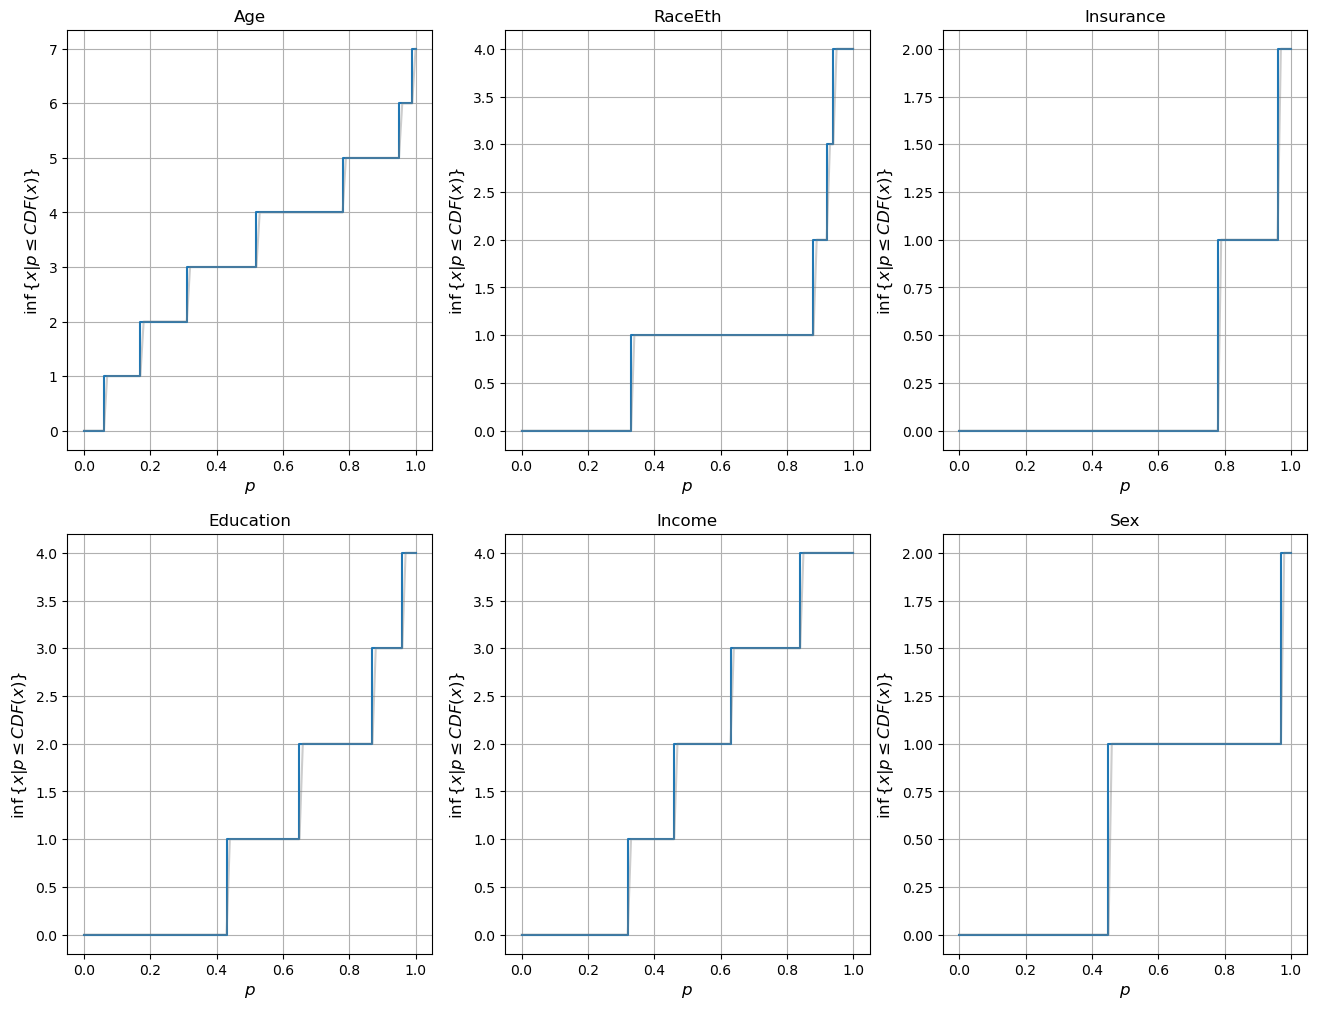

In [9]:
# probability values
plt.figure(figsize=(16, 12))
pvals = np.linspace(0, 1, 101)
for i, ecdf_obj in enumerate(ecdf_list):
    plt.subplot(2,3,i+1)
    # value of the inverse ECDF at each probability value
    yvals = [ecdf_obj.inv(p) for p in pvals]
    
    plt.step(pvals, yvals)
    # plot the generated values as a line plot
    plt.plot(pvals, yvals, color='grey', alpha=0.4)
    
    plt.xlabel('$p$', fontsize=12)
    plt.ylabel('$\inf \{ x | p \leq CDF(x)\}$', fontsize=12)
    #plt.title('Inverse CDF for the {0} Variable'.format(VARIABLES[i]))#, fontsize=16)
    plt.title('{0}'.format(VARIABLES[i]))
    plt.grid()
plt.show()

## Generate Synthetic Samples

Completely ignore correlations or any other dependencies in the data. Generate as many synthetic tuples as required to match the total count for this state.

In [10]:
print('Generating {0} synthetic tuples...'.format(NUM_SAMPLES))

Generating 500000 synthetic tuples...


In [11]:
# there are this many variables
dim = len(VARIABLES)

# 'frozen' distribution with zero mean and identity covariance
mv_normal = stats.multivariate_normal(mean = np.zeros(dim), cov = np.eye(dim))

# default 1D gaussian distribution with mean zero and std_dev 1
normal = stats.distributions.norm()

# multivariate normal tuples
Z = mv_normal.rvs(size=NUM_SAMPLES, random_state=rng)

In [12]:
# convert each component of the tuples in Z to a uniform distribution on [0,1]
U_list = []
for i in range(len(VARIABLES)):
    U_i = [normal.cdf(z) for z in Z[:,i]]
    U_list.append(U_i)

In [13]:
# transform each array in U_list using the inverse ECDF to project to the desired marginals
X_list = []
for i in range(dim):
    X_i = [ecdf_list[i].inv(u) for u in U_list[i]]
    X_list.append(X_i)

# generate tuples (one component for each variable, in order listed in VARIABLES)
synthetic_tuples = []
for i in range(NUM_SAMPLES):
    components = [X_list[k][i] for k in range(dim)]
    tup = tuple(components)
    synthetic_tuples.append(tup)
    
assert len(synthetic_tuples) == NUM_SAMPLES

#### Build output dataframe

In [14]:
final_df = pd.DataFrame(synthetic_tuples, columns=VARIABLES)
#final_df = final_df.assign(STATE = state_indicators)
final_df

,Age,RaceEth,Insurance,Education,Income,Sex
0,3,1,0,3,2,0
1,0,0,0,0,0,1
2,5,0,0,0,3,0
3,4,1,0,2,0,0
4,5,0,0,0,3,0
...,...,...,...,...,...,...
499995,4,0,0,3,3,0
499996,2,3,0,1,3,1
499997,1,0,0,3,1,1
499998,4,0,0,3,4,1


#### Find recoded AOU tuples occurring in the recoded PUMS data

#### Adjust to desired length

In [15]:
# randomly shuffle the order of the tuples
output_df = final_df.sample(frac=1).reset_index(drop=True)

# truncate to desired length
if len(output_df) > len(state_indicators):
    output_df = output_df.sample(n=len(state_indicators)).reset_index(drop=True)
    
# assign state indicators
output_df = output_df.assign(STATE = state_indicators)
    
output_df

,Age,RaceEth,Insurance,Education,Income,Sex,STATE
0,4,1,0,2,0,1,CA
1,2,1,0,4,2,0,CA
2,1,1,0,1,1,0,CA
3,5,1,0,0,4,0,CA
4,1,1,0,0,0,1,CA
...,...,...,...,...,...,...,...
260675,4,1,0,2,3,2,KY
260676,1,1,1,0,3,0,KY
260677,1,1,0,2,3,1,KY
260678,6,1,0,1,3,0,KY


#### Plot the original and synthetic PDFs for each variable

In [16]:
orig_pdfs = {}
synth_pdfs = {}

# compute weighted PDF for each variable
for i, var_name in enumerate(VARIABLES):
    
    # original pdf is from the count dict for this variable
    count_dict = ALL_VAR_COUNTS[i]
    pdf_o = np.zeros(len(count_dict))
    for val,count in count_dict.items():
        pdf_o[val] = count
    # normalize
    total = np.sum(pdf_o)
    pdf_o /= total
    orig_pdfs[var_name] = pdf_o
    
    # synthetic samples for variable i are the ith component of the synthetic tuples
    #synth_samples = [tup[i] for tup in synthetic_tuples]
    synth_samples = output_df[var_name].values
    num_bins = BIN_COUNTS[i]
        
    # synthetic PDF
    pdf_s = pdf.to_pdf(num_bins, synth_samples)
    synth_pdfs[var_name] = pdf_s

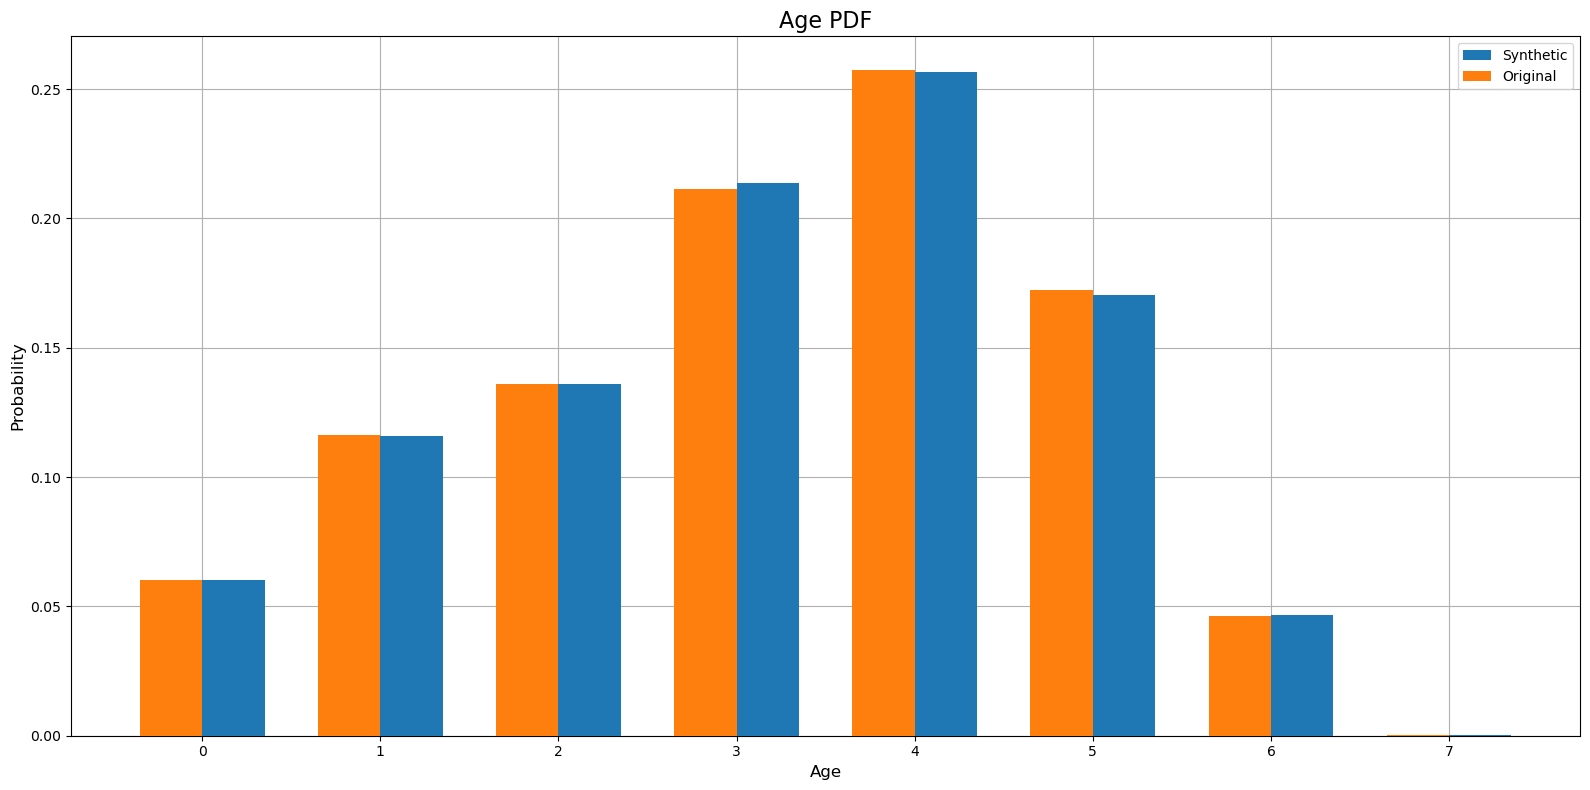

 Original PDF : [0.06  0.116 0.136 0.211 0.257 0.172 0.046 0.   ]
Synthetic PDF : [0.06  0.116 0.136 0.214 0.257 0.171 0.047 0.   ]


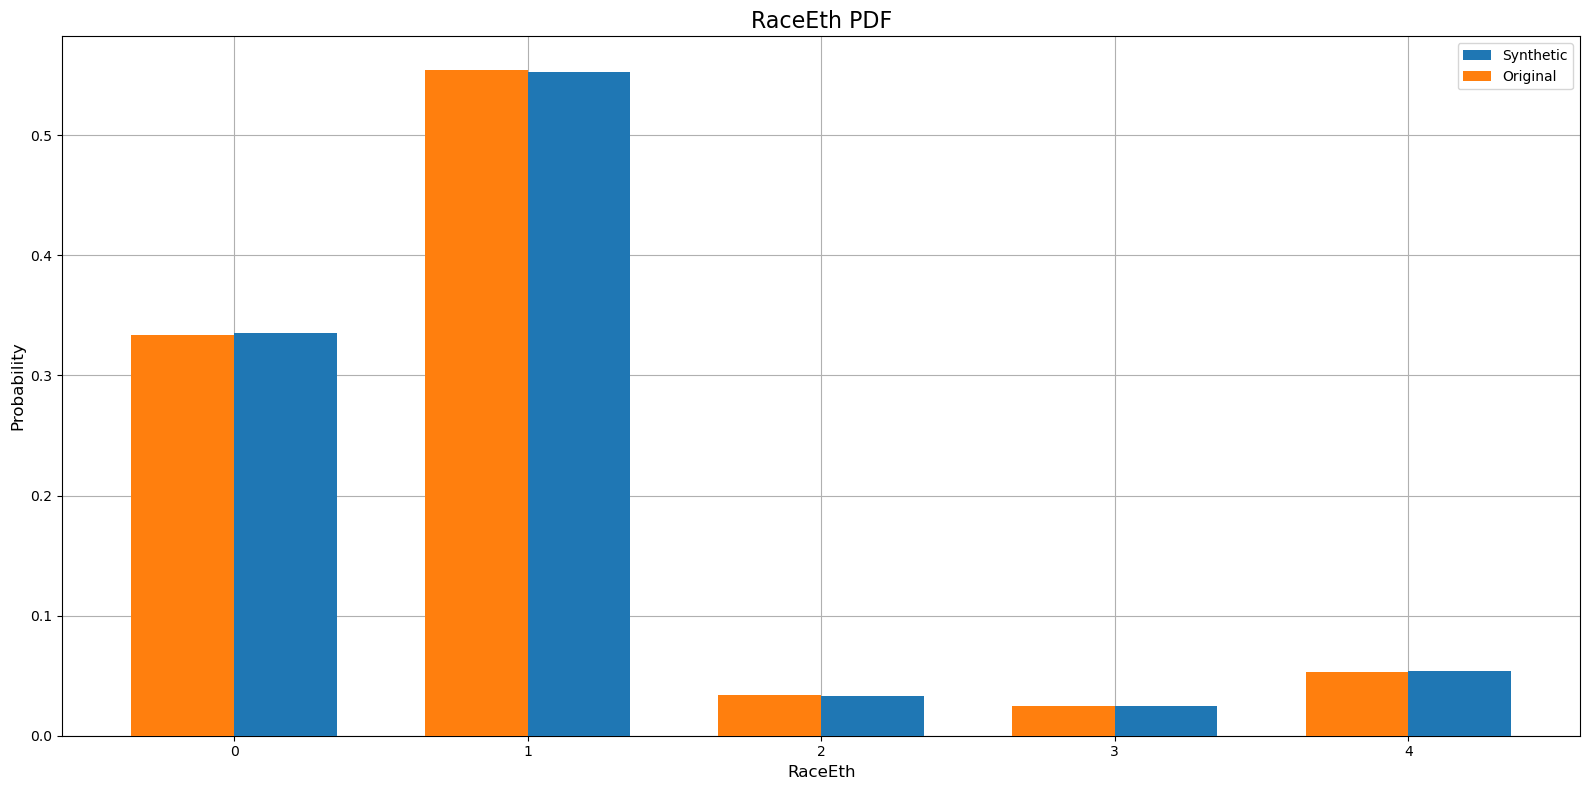

 Original PDF : [0.333 0.555 0.034 0.025 0.053]
Synthetic PDF : [0.336 0.552 0.033 0.025 0.054]


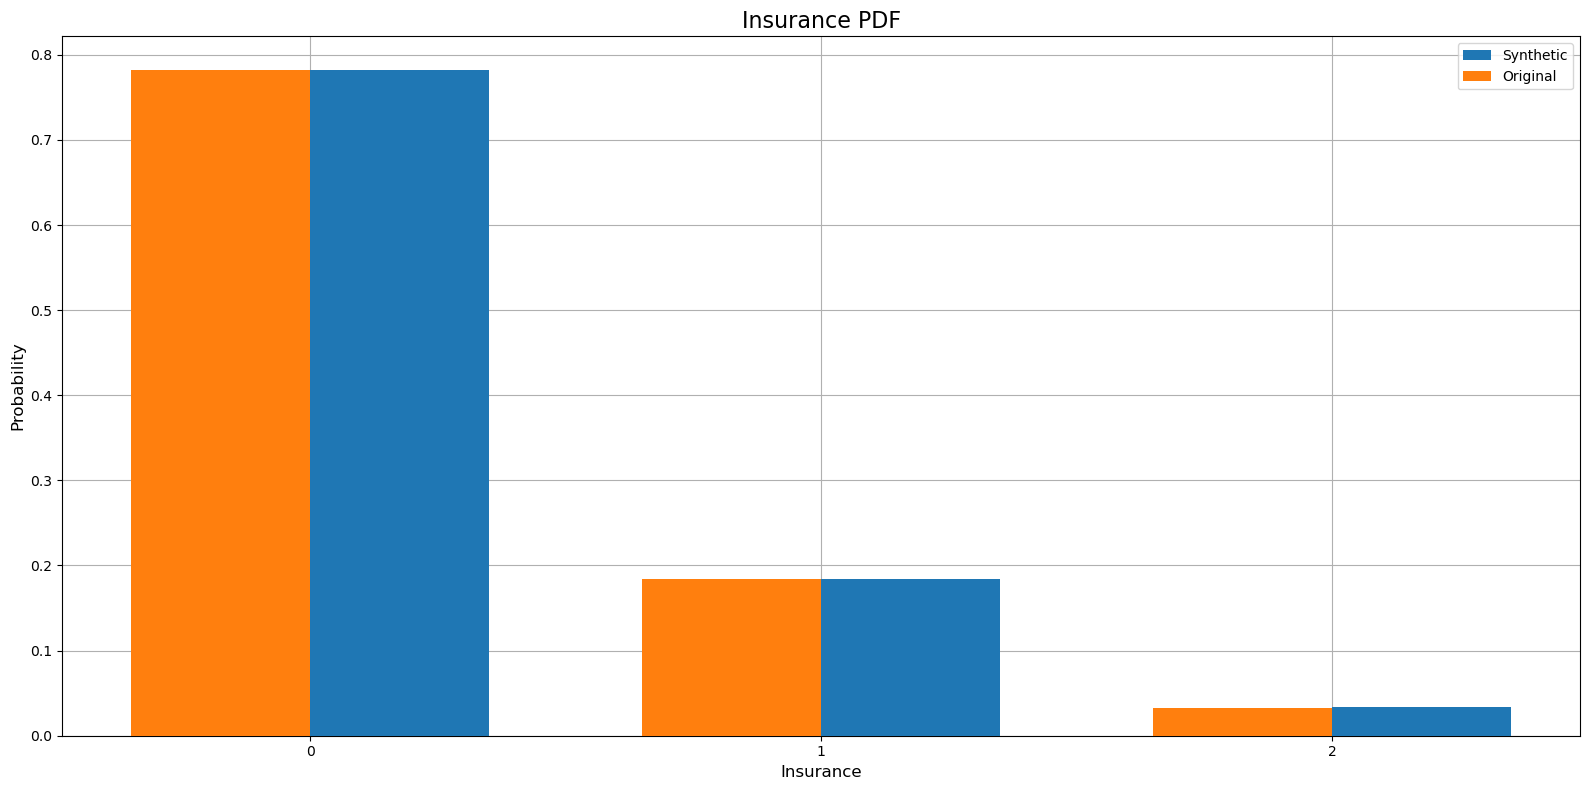

 Original PDF : [0.782 0.185 0.033]
Synthetic PDF : [0.783 0.184 0.033]


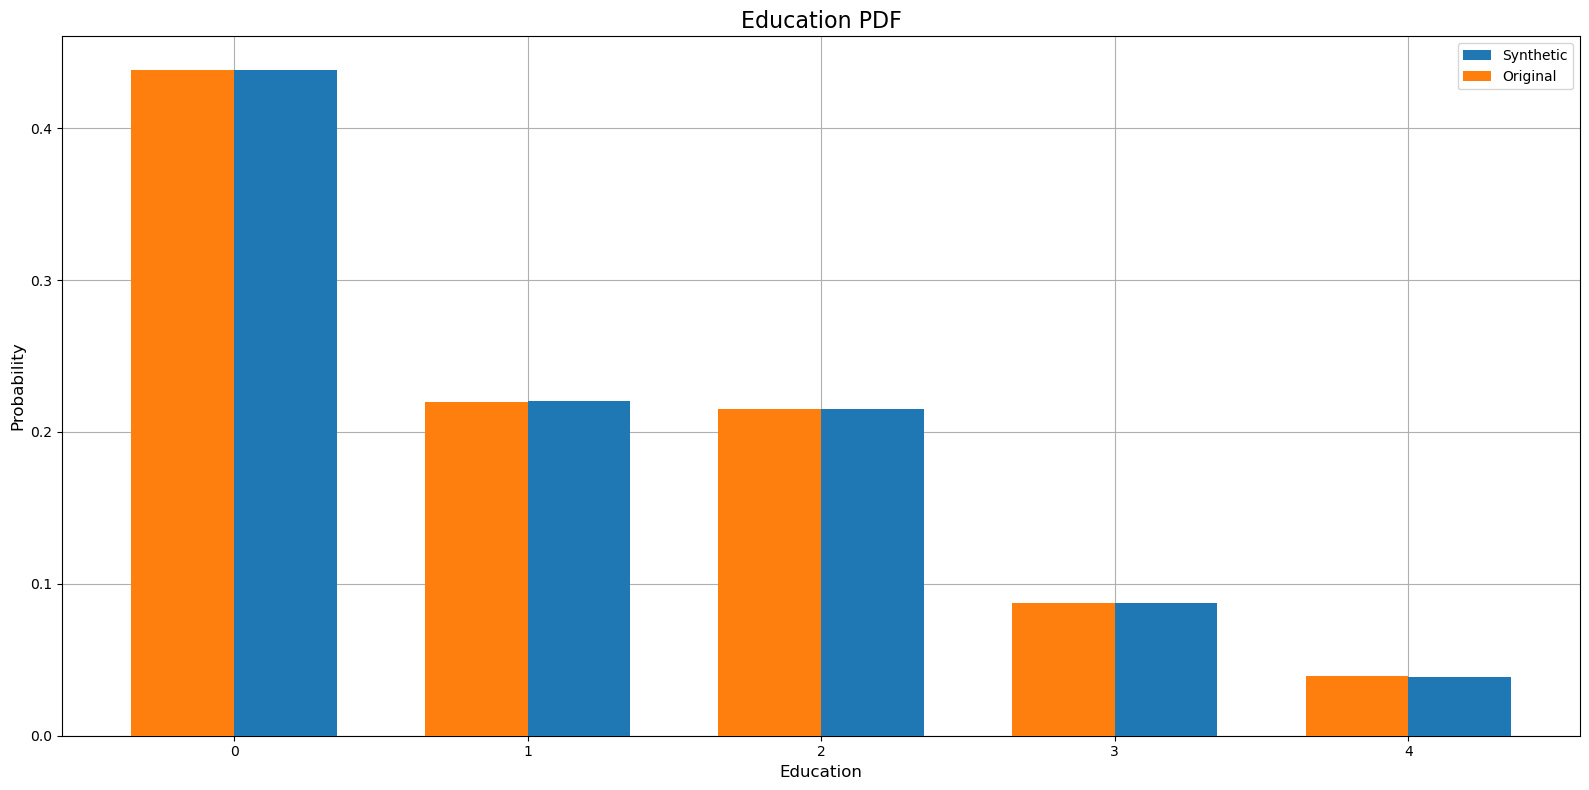

 Original PDF : [0.439 0.22  0.215 0.087 0.039]
Synthetic PDF : [0.439 0.22  0.215 0.088 0.039]


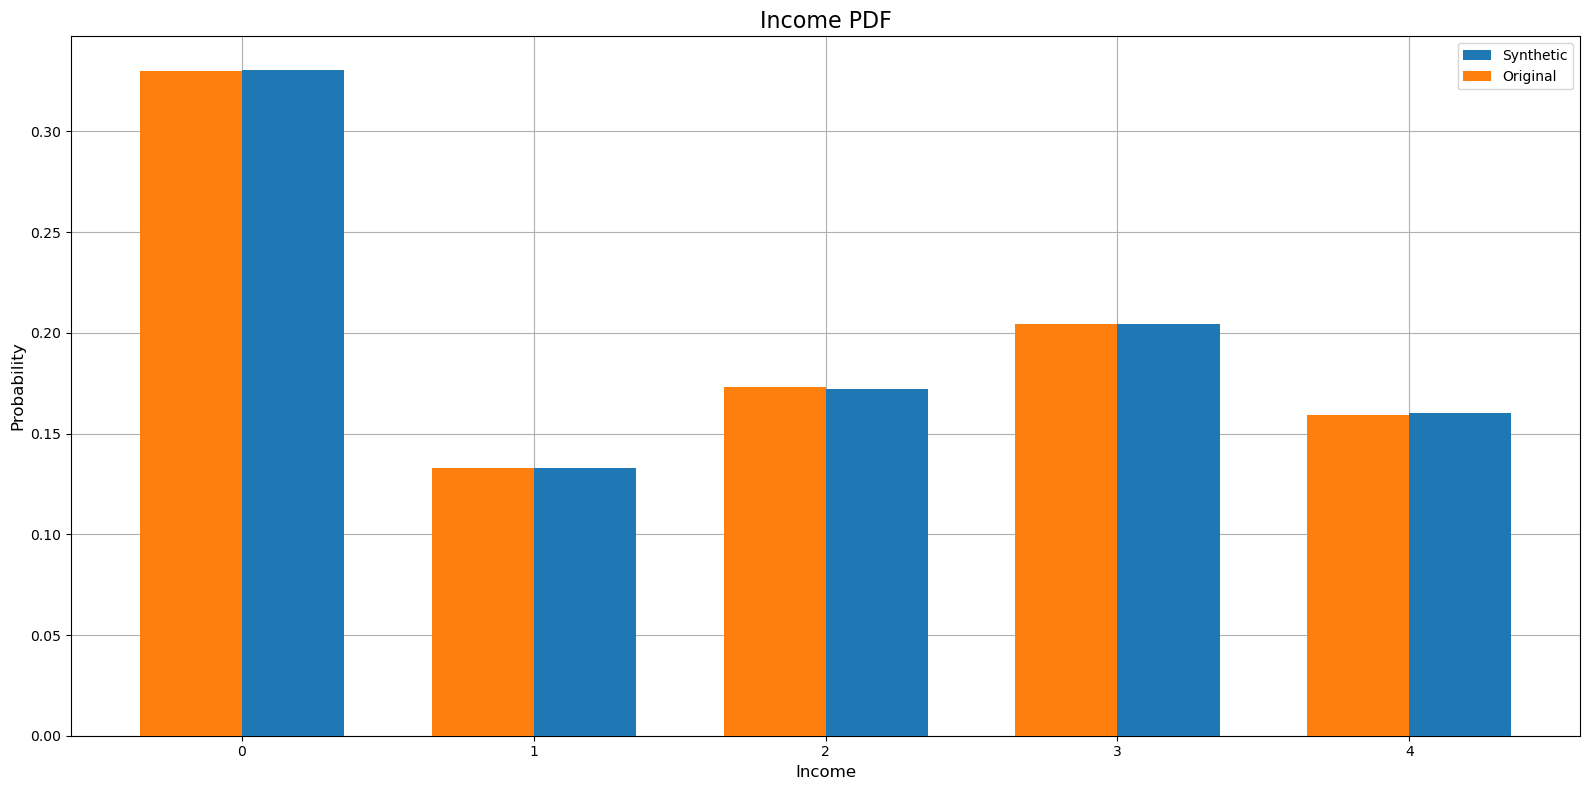

 Original PDF : [0.33  0.133 0.173 0.205 0.159]
Synthetic PDF : [0.331 0.133 0.172 0.204 0.16 ]


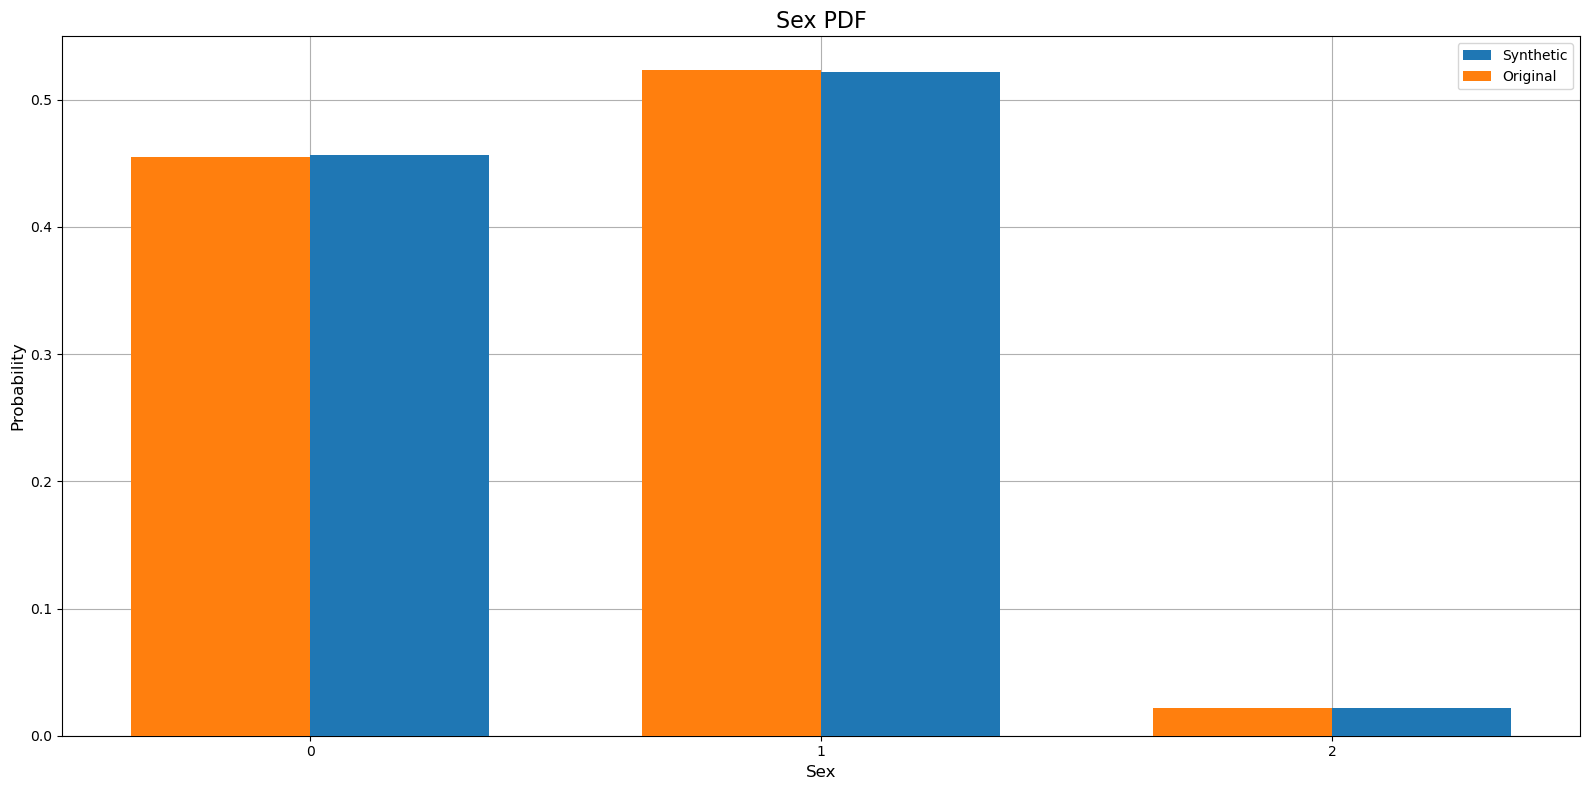

 Original PDF : [0.455 0.524 0.022]
Synthetic PDF : [0.457 0.522 0.022]


In [17]:
# display precision
P = 3

for i, var_name in enumerate(VARIABLES):
    plots.dual_histogram_from_pdfs(var_name, orig_pdfs[var_name], synth_pdfs[var_name],
                                   labels=['Original', 'Synthetic'])
    
    print(' Original PDF : {0}'.format(np.array_str(orig_pdfs[var_name],  precision=P)))
    print('Synthetic PDF : {0}'.format(np.array_str(synth_pdfs[var_name], precision=P)))

#### Write Synthetic Tuples to Disk

In [18]:
output_cols = [OUTPUT_VAR_MAP[col] for col in output_df if col != 'STATE']
output_cols.append('STATE')
assert len(output_cols) == len(output_df.columns)
output_df.to_csv(OUTPUT_FILE, index=False, header=output_cols)
print('Wrote file "{0}".'.format(OUTPUT_FILE))

Wrote file "data/synthetic_aou.csv".
